In [67]:
import os 
import cv2
import numpy as np
from tqdm import tqdm



Make our DataSet ! 

In [68]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

#if the immages are all different sizes, you could ether 
# # resize everithing to a stendard size but it will distord
# # images, or you coud resize and keep the aspect ratio and add
# # padding (white or black) to make the immage the right size

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        #check for Balancing 

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        # print(f"Erreur lors du traitement de l'image: {path}, Erreur: {str(e)}")
                        pass

        np.random.shuffle(self.training_data)
        try:
            self.training_data = np.array(self.training_data, dtype=object)
            np.save("training_data.npy", self.training_data)
        except ValueError as e:
            # print("Erreur lors de la conversion en array NumPy. Détails de l'erreur :", str(e))
            # for i, data in enumerate(self.training_data):
            #     img, label = data
            #     print(f"Image {i}, Forme: {img.shape}, Label: {label}")
            pass
        print('Cats:', self.catcount)
        print('Dogs:', self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|██████████| 12501/12501 [00:07<00:00, 1766.61it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:07<00:00, 1685.70it/s]


Cats: 12476
Dogs: 12470


How to convert to 1 HOT VECTOR

In [69]:
ONEHV = np.eye(2)
cats = ONEHV[0]
dogs = ONEHV[1]
print ("cats: ",cats,"dogs: ",dogs)

cats:  [1. 0.] dogs:  [0. 1.]


training and testing data

In [70]:
training_data = np.load("training_data.npy",allow_pickle= True)

In [71]:
print(len(training_data))

24946


In [72]:
print(training_data[0])

[array([[214, 216, 219, ..., 230, 228, 229],
        [212, 215, 217, ..., 231, 229, 229],
        [214, 216, 217, ..., 231, 229, 230],
        ...,
        [ 32,  28,  24, ..., 219, 217, 213],
        [ 30,  28,  25, ..., 216, 211, 208],
        [ 32,  27,  27, ..., 213, 210, 204]], dtype=uint8) array([1., 0.])]


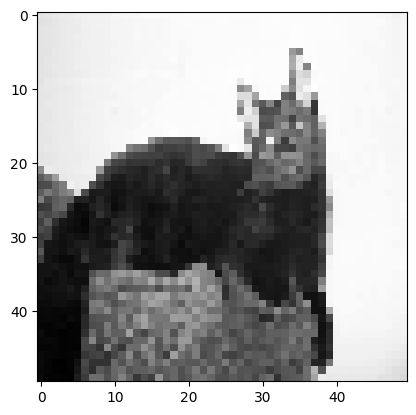

In [73]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0], cmap= "gray")
plt.show()

Building the network

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Net Class

In [75]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)

        # this is to determine the flatn of the output of conv3
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear ,512)
        self.fc2 = nn.Linear(512,2)
    
    def convs(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,(2,2))

        if self._to_linear is None:
            #numel() counts how many elements in x[0]
            self._to_linear = x[0].numel()
            print(self._to_linear)
        return x
    
    def forward (self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return (F.softmax(x,dim = 1))
    
    
    
device = torch.device("cuda" )

net = Net().to(device)




512


Making sets and Optimizer

In [76]:
import torch.optim as optim

lr= 0.001

optimizer = optim.Adam(net.parameters(), lr= 0.001)

loss_function = nn.MSELoss()


#then we have to separate the X __> imgs and y the labels

#convert list of array in one single aray for performence (much faster)

X_np = np.array([i[0] for i in training_data])

# Convert numpy array in torch tensort

X = torch.tensor(X_np).view(-1, 50, 50).float()

X = X/255.0

y=torch.tensor([i[1] for i in training_data]).float()

#VAL_PCT is the purcentage of the train data you wanna use in a verify/test data

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print (len(X))
print (val_size)


24946
2494


In [77]:

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


Training

100%|██████████| 351/351 [00:01<00:00, 330.65it/s]


tensor(0.2668, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 998.72it/s]


Accuracy:  0.601


100%|██████████| 351/351 [00:01<00:00, 339.60it/s]


tensor(0.2140, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 1000.88it/s]


Accuracy:  0.652


100%|██████████| 351/351 [00:01<00:00, 338.91it/s]


tensor(0.1825, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 991.77it/s]


Accuracy:  0.725


100%|██████████| 351/351 [00:01<00:00, 337.16it/s]


tensor(0.1545, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 995.91it/s]


Accuracy:  0.747


100%|██████████| 351/351 [00:01<00:00, 333.67it/s]


tensor(0.1393, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 1001.78it/s]


Accuracy:  0.762


100%|██████████| 351/351 [00:01<00:00, 329.06it/s]


tensor(0.1309, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 996.26it/s]


Accuracy:  0.766


100%|██████████| 351/351 [00:01<00:00, 335.15it/s]


tensor(0.1190, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 1000.69it/s]


Accuracy:  0.761


100%|██████████| 351/351 [00:01<00:00, 337.06it/s]


tensor(0.0649, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 994.17it/s]


Accuracy:  0.774


100%|██████████| 351/351 [00:01<00:00, 336.71it/s]


tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 996.34it/s]


Accuracy:  0.77


100%|██████████| 351/351 [00:01<00:00, 336.22it/s]


tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 990.64it/s]


Accuracy:  0.776


100%|██████████| 351/351 [00:01<00:00, 335.11it/s]


tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 998.20it/s]


Accuracy:  0.771


100%|██████████| 351/351 [00:01<00:00, 330.32it/s]


tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 994.71it/s]


Accuracy:  0.785


100%|██████████| 351/351 [00:01<00:00, 332.12it/s]


tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 992.36it/s]


Accuracy:  0.786


100%|██████████| 351/351 [00:01<00:00, 334.24it/s]


tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 983.71it/s]


Accuracy:  0.785


100%|██████████| 351/351 [00:01<00:00, 332.61it/s]


tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 39/39 [00:00<00:00, 987.40it/s]


Accuracy:  0.783


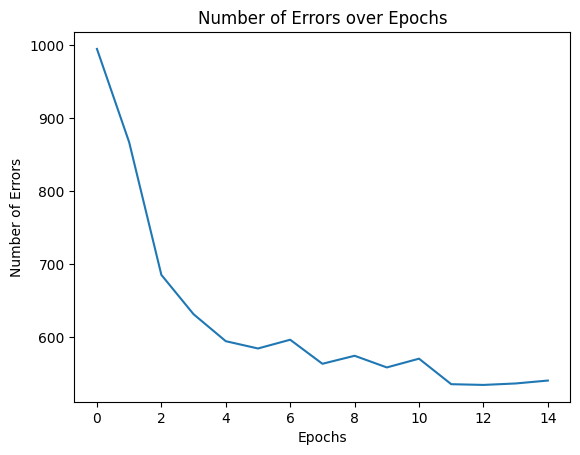

In [78]:

BATCH_SIZE = 64
EPOCHS = 15
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=int(((len(train_X) - 1) // BATCH_SIZE + 1) * EPOCHS))
errors_over_epochs = []


def Test():
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in tqdm(range(0, len(test_X), BATCH_SIZE)):
            batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device).float()
            batch_y = test_y[i:i+BATCH_SIZE].to(device).float()

            outputs = net(batch_X)
            

            predicted_classes = torch.argmax(outputs, dim=1)
            real_classes = torch.argmax(batch_y, dim=1)
            correct += (predicted_classes == real_classes).sum().item()
            total += batch_X.size(0)

    accuracy = correct / total
    print("Accuracy: ", round(accuracy, 3))
    return total - correct




for epoch in range (EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        
        
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device).float()

        batch_y = train_y[i:i+BATCH_SIZE].to(device).float()

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(loss)
    errors_over_epochs.append(Test())
    
    



plt.plot(errors_over_epochs)
plt.xlabel('Epochs')
plt.ylabel('Number of Errors')
plt.title('Number of Errors over Epochs')
plt.show()


In [79]:
def Test():
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))
    return (total - correct)
Test()

100%|██████████| 2494/2494 [00:00<00:00, 2975.80it/s]

Accuracy:  0.783


540

Save my Network

In [80]:

import torch.onnx

torch.save(net.state_dict(), 'CNN_chat_chien.pth')

net.load_state_dict(torch.load('CNN_chat_chien.pth'))
net.eval()



Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [81]:
IMG_name = "cat_web.jpg"

IMG_SIZE = 50


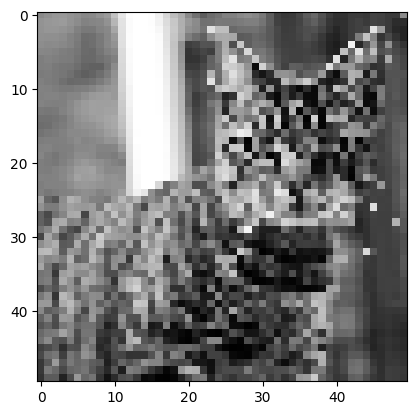

Tenseur d'entrée: tensor([[[[0.5412, 0.5686, 0.5922,  ..., 0.2275, 0.2275, 0.5451],
          [0.5804, 0.5922, 0.6000,  ..., 0.2275, 0.1765, 0.1765],
          [0.5725, 0.5882, 0.5882,  ..., 0.2275, 0.1608, 0.1451],
          ...,
          [0.2196, 0.3490, 0.6078,  ..., 0.2157, 0.2196, 0.1961],
          [0.2235, 0.4784, 0.4157,  ..., 0.2431, 0.2392, 0.2196],
          [0.1961, 0.3569, 0.3569,  ..., 0.2431, 0.2392, 0.2118]]]])
Sortie du modèle: tensor([[0.9375, 0.0625]], device='cuda:0')


'Cat'

In [82]:


def Img_import_to_tensor(IMG_name, IMG_SIZE):
    path = os.path.join(IMG_name)

    imgweb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    imgweb = cv2.resize(imgweb, (IMG_SIZE, IMG_SIZE))
    plt.imshow(imgweb, cmap= "gray")
    plt.show()
    imgweb = torch.tensor(imgweb, dtype=torch.float32) / 255  # Convertir en float et normaliser
    imgweb = imgweb.view(1, 1, 50, 50)  # Ajouter une dimension de lot
    print("Tenseur d'entrée:", imgweb)
    return (imgweb)

def Img_import_to_array(IMG_name,IMG_SIZE):

    path = os.path.join(IMG_name)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32)  
    img = img / 255.0

    img = img.reshape(1, 1, IMG_SIZE, IMG_SIZE)

    return img

def Tell_from_import(IMG_name,IMG_SIZE):

    
    
    with torch.no_grad():
        output = net(Img_import_to_tensor(IMG_name,IMG_SIZE).to(device))
        print("Sortie du modèle:", output)

    predicted_class = torch.argmax(output)
    if predicted_class == 0:
        return "Cat"
    elif predicted_class == 1:
        return "Dog"
    else:
        return "Not sure"

Tell_from_import(IMG_name, IMG_SIZE)


 Conversion and exportation of PyTorch model to ONNX

In [83]:

x = torch.randn(1, 1, 50, 50).to(device)
torch.onnx.export(net, x, "sortie_CNN_chat_chien.onnx")



Determin the imput name

In [84]:
import onnxruntime as ort

# Charger le modèle ONNX
ort_session = ort.InferenceSession("sortie_CNN_chat_chien.onnx")


input_name = ort_session.get_inputs()[0].name
print("Nom de l'entrée attendue par le modèle ONNX :", input_name)



Nom de l'entrée attendue par le modèle ONNX : input.1


In [85]:




input_data = Img_import_to_array(IMG_name, IMG_SIZE)
input_data = input_data.astype(np.float32)  # Assurez-vous que les données sont au bon type

# Obtenir le nom de l'entrée attendue par le modèle ONNX
input_name = ort_session.get_inputs()[0].name

# Exécuter le modèle avec les données d'entrée
outputs = ort_session.run(None, {input_name: input_data})

# Afficher les résultats
print(outputs)


[array([[0.9374189 , 0.06258117]], dtype=float32)]
